In [2]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [9]:
source('main.R')
house_prices$helpers$import_libs()

combined_dataset <-
    # load data
    house_prices$helpers$load_data() %>%
    #select(-one_of(house_prices$attributes_selection$discared_cat_vars)) %>%
    #select(-one_of(house_prices$attributes_selection$discared_num_vars)) %>%
    # remove outliers
    (house_prices$outliers$remove_outliers) %>%
    # fix NA values
    (house_prices$missing$categ$replace_with_most_common) %>%
    (house_prices$missing$categ$fix_valid) %>%
    (house_prices$missing$numeric$replace_with_zero) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice, -Id)

#####################
# transform numeric #
#####################

transformation_config <- house_prices$trans$numeric$get_transformation_config(combined_dataset)

transformation_config

combined_dataset <-
    house_prices$trans$numeric$apply_transform(combined_dataset, transformation_config)

#########################
# transform categorical #
#########################

combined_dataset_after_categ <-
    house_prices$trans$categ$rating_transform(combined_dataset, price_log)

combined_dataset_after_categ %>% head

var,predictor,score
BsmtUnfSF,sqrt,79.97603
GrLivArea,log,91.15794
LotArea,log,73.38993
TotRmsAbvGrd,log,30.68502
X1stFlrSF,log,90.77166


Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,⋯,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,dataSource,price_log
2.531822,2.564039,2.540871,2.320042,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,61,0,0,0,0,0,2,2008,train,12.24769
2.531822,2.564039,2.540871,3.295455,2.231818,2.553429,3.066343,2.57887,1.987500,2.50277,⋯,0,0,0,0,0,0,5,2007,train,12.10901
2.531822,2.564039,2.540871,2.675439,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,42,0,0,0,0,0,9,2008,train,12.31717
2.531822,2.564039,3.046154,2.320042,2.231818,2.553429,1.847458,2.57887,2.547619,2.50277,⋯,35,272,0,0,0,0,2,2006,train,11.84940
2.531822,2.564039,2.540871,2.900452,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,84,0,0,0,0,0,12,2008,train,12.42922
2.531822,2.564039,2.540871,2.320042,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,30,0,320,0,0,700,10,2009,train,11.87060


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.7641906,0.7638664,0.194236,2357.618,0,3,321.8864,-635.7728,-614.6335,54.89371,1455


term,estimate,std.error,statistic,p.value
(Intercept),7.6588878,0.126036731,60.76711,0.000000e+00
GrLivArea,0.4565688,0.019430309,23.49777,9.051174e-104
OverallQual,0.1718658,0.004660648,36.87594,9.636469e-211


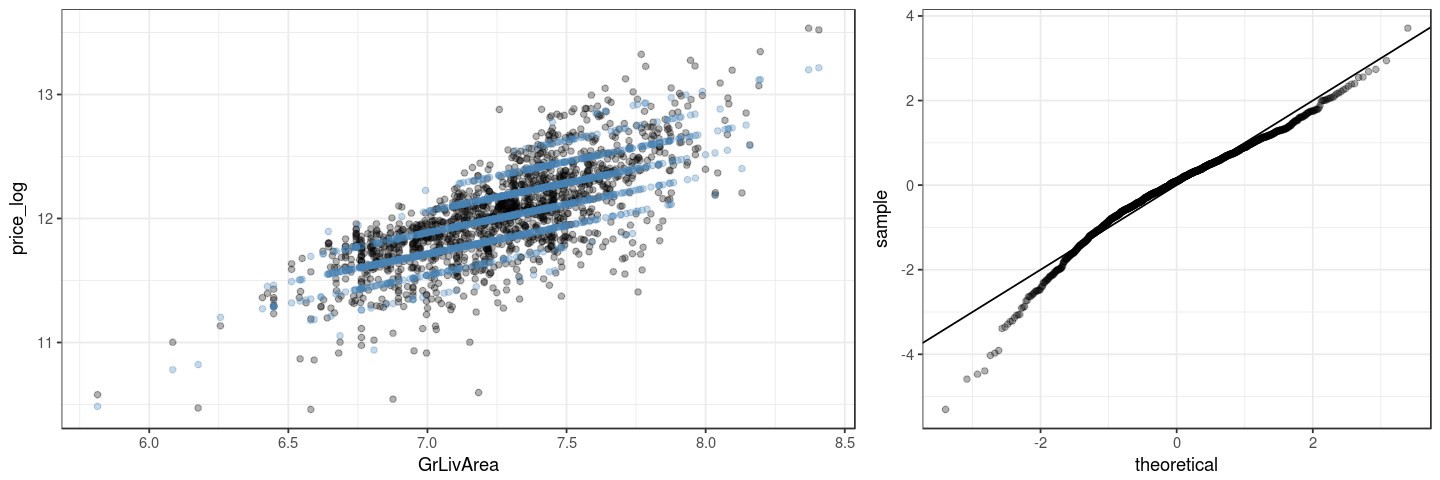

In [10]:
options(repr.plot.width = 12, repr.plot.height = 4)

training_dataset <- combined_dataset_after_categ %>% filter(dataSource == 'train') %>% select(-dataSource)

mod <- lm(price_log ~ GrLivArea + OverallQual, data=training_dataset)

mod %>% glance
mod %>% tidy

plt_scatter <-
    mod %>%
    augment %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
    geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
    theme_bw()

plt_qq <-
    mod %>%
    augment %>%
    select(resid=.resid) %>%
    mutate(
        resid_normed = (resid - mean(resid)) / sd(resid)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=resid_normed), alpha=0.3) +
    geom_abline(slope=1, color="black") +
    theme_bw()

grid.arrange(
    plt_scatter, plt_qq, 
    layout_matrix=rbind(c(1, 2)), 
    widths=c(60, 40)
)

In [11]:
source('main.R')

report <- house_prices$model_selection$lm$greedy_r2_adj(
    'price_log ~ GrLivArea', 
    training_dataset,
    R2_GAIN_INFIMUM = 0.3, 
    MAX_CORR_SUPREMUM = 0.7, 
    CORR_SENSITIVITY = 0.1
)

report %>%
group_by(base_formula) %>%
top_n(1, r2_gain_adj)

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,r2_gain_adj
price_log ~ GrLivArea,OverallQual,price_log ~ GrLivArea + OverallQual,0.5438044,0.7641906,40.5267438,0.6088750,38.2007932
price_log ~ GrLivArea + OverallQual,BsmtFinSF1,price_log ~ GrLivArea + OverallQual + BsmtFinSF1,0.7641906,0.8112984,6.1644091,0.2224668,6.0302559
price_log ~ GrLivArea + OverallQual + BsmtFinSF1,Neighborhood,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood,0.8112984,0.8493875,4.6948385,0.6790092,4.3963241
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood,GarageArea,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea,0.8493875,0.8611900,1.3895276,0.5572300,1.3161858
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea,OverallCond,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond,0.8611900,0.8741046,1.4996178,0.2273702,1.4662790
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond,TotalBsmtSF,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF,0.8741046,0.8845829,1.1987548,0.5385945,1.1374902
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF,SaleCondition,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition,0.8845829,0.8905367,0.6730544,0.3284304,0.6516522
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition,MSSubClass,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + MSSubClass,0.8905367,0.8965875,0.6794614,0.5645551,0.6431519
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + MSSubClass,CentralAir,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + MSSubClass + CentralAir,0.8965875,0.8998334,0.3620208,0.2872452,0.3519123
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + MSSubClass + CentralAir,LotArea,price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + MSSubClass + CentralAir + LotArea,0.8998334,0.9028762,0.3381533,0.3744884,0.3259469


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.8998334,0.8991411,0.1269428,1299.893,0,11,946.048,-1868.096,-1804.678,23.31764,1447


term,estimate,std.error,statistic,p.value
(Intercept),7.4486017341,9.698292e-02,76.803230,0.000000e+00
GrLivArea,0.3827193739,1.352616e-02,28.294764,1.501066e-140
OverallQual,0.0725144878,3.970499e-03,18.263319,3.215749e-67
BsmtFinSF1,0.0001198173,8.907613e-06,13.451107,5.976158e-39
Neighborhood,0.0979783044,6.146432e-03,15.940679,7.902561e-53
GarageArea,0.0001934631,2.057051e-05,9.404877,1.966724e-20
OverallCond,0.0444071891,3.181605e-03,13.957481,1.244249e-41
TotalBsmtSF,0.0001409697,1.121987e-05,12.564295,1.938274e-34
SaleCondition,0.0943722513,1.016263e-02,9.286204,5.663225e-20
MSSubClass,0.0530269267,6.734533e-03,7.873884,6.695396e-15


,GrLivArea,OverallQual,BsmtFinSF1,Neighborhood,GarageArea,OverallCond,TotalBsmtSF,SaleCondition,MSSubClass,CentralAir
GrLivArea,1.0000000,0.6088750,0.13001367,0.4674791,0.4674733,-0.10028026,0.4187766,0.15633902,0.4468994,0.1296896
OverallQual,0.6088750,1.0000000,0.22246684,0.6790092,0.5572300,-0.09044230,0.5385945,0.32304052,0.4887833,0.2725223
BsmtFinSF1,0.1300137,0.2224668,1.00000000,0.2426179,0.2732443,-0.04298706,0.4676236,0.01945481,0.1455381,0.1725536
Neighborhood,0.4674791,0.6790092,0.24261785,1.0000000,0.5209302,-0.22737022,0.4659706,0.32843038,0.5645551,0.2631064
GarageArea,0.4674733,0.5572300,0.27324429,0.5209302,1.0000000,-0.15050263,0.4750691,0.30386369,0.3866010,0.2314561
OverallCond,-0.1002803,-0.0904423,-0.04298706,-0.2273702,-0.1505026,1.00000000,-0.1749309,-0.09779268,-0.1415573,0.1191841
TotalBsmtSF,0.4187766,0.5385945,0.46762362,0.4659706,0.4750691,-0.17493095,1.0000000,0.23451793,0.2048821,0.2168935
SaleCondition,0.1563390,0.3230405,0.01945481,0.3284304,0.3038637,-0.09779268,0.2345179,1.00000000,0.1899675,0.1046709
MSSubClass,0.4468994,0.4887833,0.14553807,0.5645551,0.3866010,-0.14155729,0.2048821,0.18996748,1.0000000,0.2872452
CentralAir,0.1296896,0.2725223,0.17255361,0.2631064,0.2314561,0.11918415,0.2168935,0.10467089,0.2872452,1.0000000


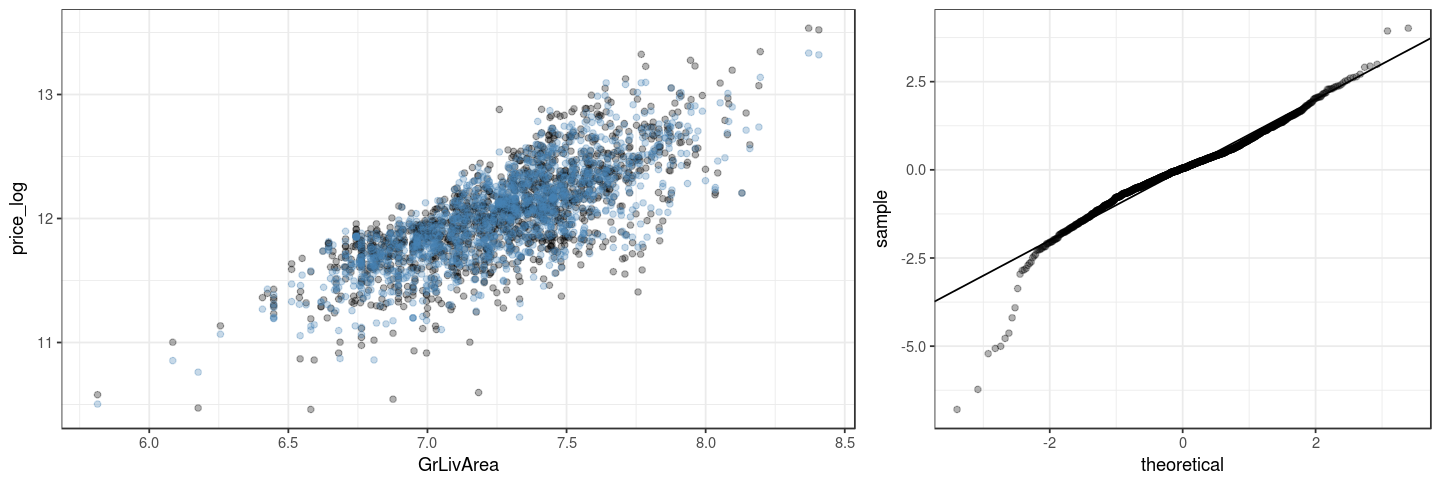

In [12]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
    price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + MSSubClass + CentralAir,
    data=training_dataset
)

mod %>% glance
mod %>% tidy
cor(training_dataset[setdiff(names(mod$coefficients), '(Intercept)')])

plt_scatter <-
    mod %>%
    augment %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
    geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
    theme_bw()

plt_qq <-
    mod %>%
    augment %>%
    select(resid=.resid) %>%
    mutate(
        resid_normed = (resid - mean(resid)) / sd(resid)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=resid_normed), alpha=0.3) +
    geom_abline(slope=1, color="black") +
    theme_bw()

grid.arrange(
    plt_scatter, plt_qq, 
    layout_matrix=rbind(c(1, 2)), 
    widths=c(60, 40)
)

In [18]:
L2Loss = function (vec) {
    sum(vec**2) / length(vec)
}

In [24]:
dataset <- 
    combined_dataset %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

dataset %>% nrow

caret::createDataPartition(
    y = dataset[['price_log']], 
    p = 0.5, 
    list = T, 
    times = 1
)[[1]] -> sample_index

sample_index %>% length

test_y <- dataset[-sample_index, 'price_log'][[1]]

dataset <- 
    dataset %>% 
    mutate(price_log = replace(price_log, -sample_index, NA))

dataset <-
    house_prices$trans$categ$rating_transform(dataset, price_log)

trainset <- dataset[sample_index,]
testset <- dataset[-sample_index,]

trainset %>% head(2)

mod <- lm(
    price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + Neighborhood + GarageArea + OverallCond + TotalBsmtSF + SaleCondition + MSSubClass + CentralAir,
    data=trainset
)

testset <- 
    testset %>% 
    mutate(
        price_log = test_y,
        price_log_predicted = predict(mod, testset)
    )
testset %>% head(2)

mod %>% glance
mod %>% tidy

[1] 1458

[1] 730

,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,price_log
2,2.534815,2.580592,2.559006,3.19403,2.243243,2.564873,3.08,2.597923,2.046512,2.502075,⋯,298,0,0,0,0,0,0,5,2007,12.10901
3,2.534815,2.580592,2.559006,2.73913,3.269231,2.564873,3.08,2.597923,2.546042,2.502075,⋯,0,42,0,0,0,0,0,9,2008,12.31717


Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,⋯,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,price_log,price_log_predicted
2.534815,2.580592,2.559006,2.36157,3.269231,2.564873,3.080000,2.597923,2.546042,2.502075,⋯,61,0,0,0,0,0,2,2008,12.24769,12.26790
2.534815,2.580592,3.135135,2.36157,2.243243,2.564873,1.839744,2.597923,2.546042,2.502075,⋯,35,272,0,0,0,0,2,2006,11.84940,12.13233


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.9008414,0.8994622,0.1256707,653.2007,0,11,483.8026,-943.6053,-888.4887,11.35526,719


term,estimate,std.error,statistic,p.value
(Intercept),7.3766059520,1.360007e-01,54.239463,2.535902e-256
GrLivArea,0.4085792792,1.924931e-02,21.225662,5.293386e-78
OverallQual,0.0683007582,5.451610e-03,12.528549,1.033195e-32
BsmtFinSF1,0.0001343008,1.284647e-05,10.454291,6.552184e-24
Neighborhood,0.0939900761,8.567550e-03,10.970473,5.344387e-26
GarageArea,0.0001867133,2.914213e-05,6.406989,2.682835e-10
OverallCond,0.0345004616,4.358103e-03,7.916393,9.268370e-15
TotalBsmtSF,0.0001217401,1.543870e-05,7.885384,1.165260e-14
SaleCondition,0.1025380218,1.397945e-02,7.334912,5.998940e-13
MSSubClass,0.0505741029,9.286952e-03,5.445716,7.088414e-08


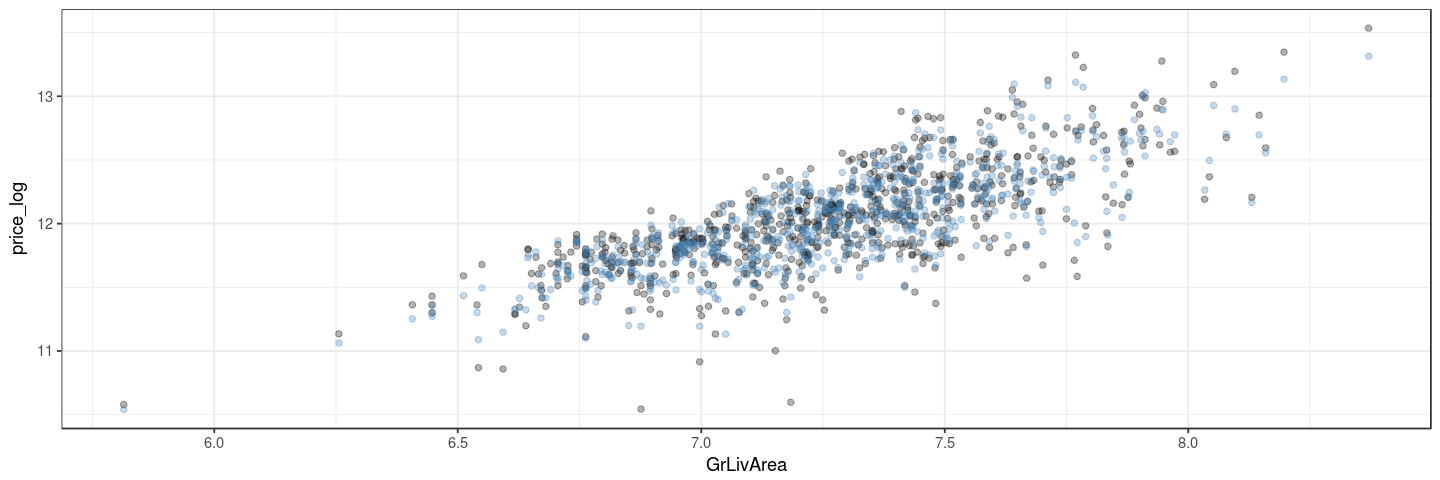

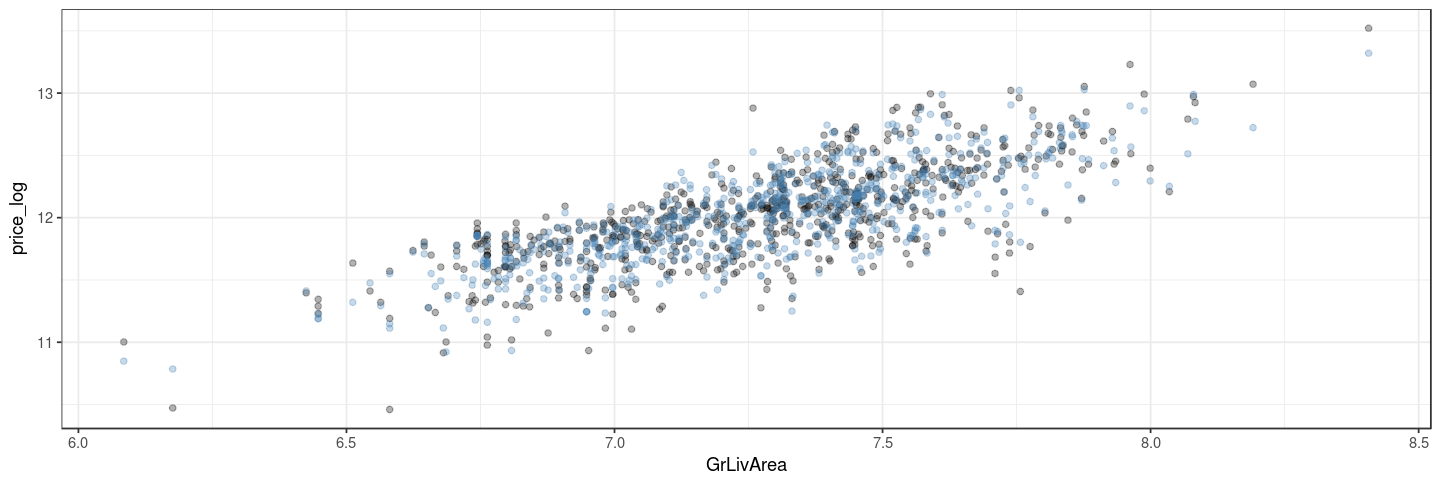

In [33]:
testset %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
geom_point(aes(x=GrLivArea, y=price_log_predicted), alpha=0.3, color='steelblue') +
theme_bw()

mod %>%
augment %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
theme_bw()

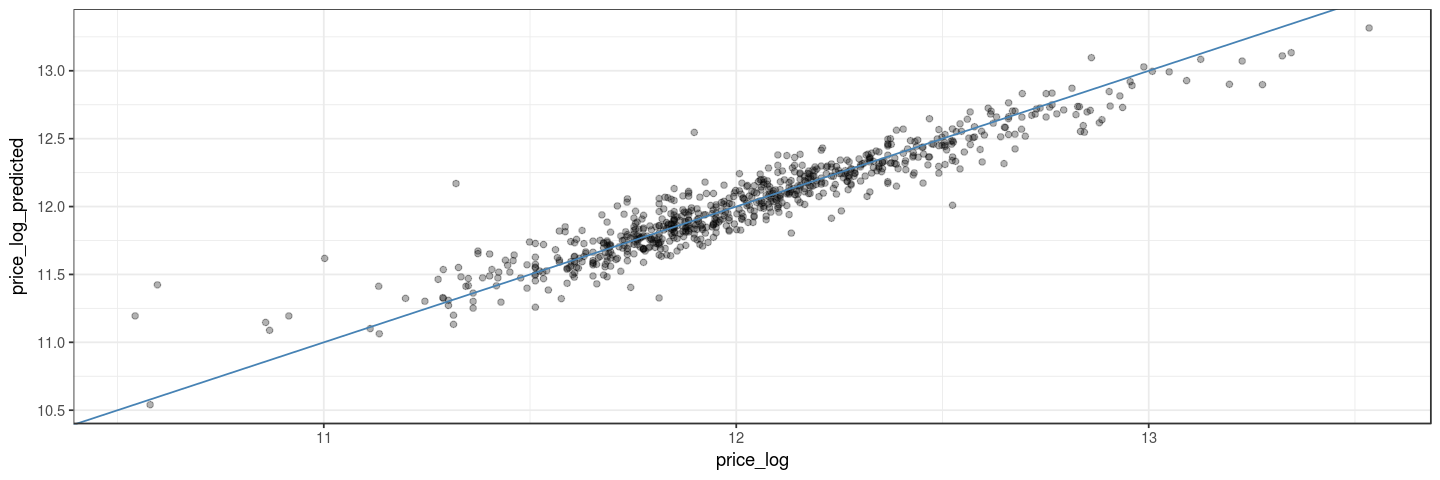

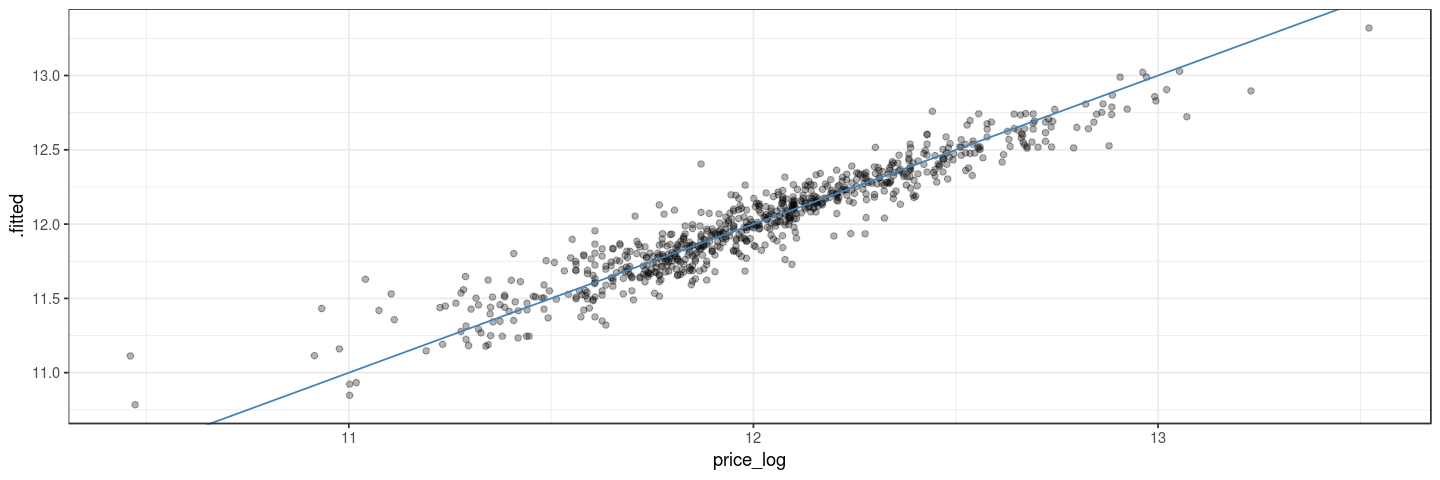

In [34]:
testset %>%
ggplot() +
geom_point(aes(x=price_log, y=price_log_predicted), alpha=0.3) +
geom_abline(intercept=0, slope=1, color='steelblue') +
theme_bw()

mod %>%
augment %>%
ggplot() +
geom_point(aes(x=price_log, y=.fitted), alpha=0.3) +
geom_abline(intercept=0, slope=1, color='steelblue') +
theme_bw()